Random Forest Mean ROC AUC Score for xyz_vaccine: 0.8276703818591449
XGBoost Mean ROC AUC Score for xyz_vaccine: 0.8237060967969798


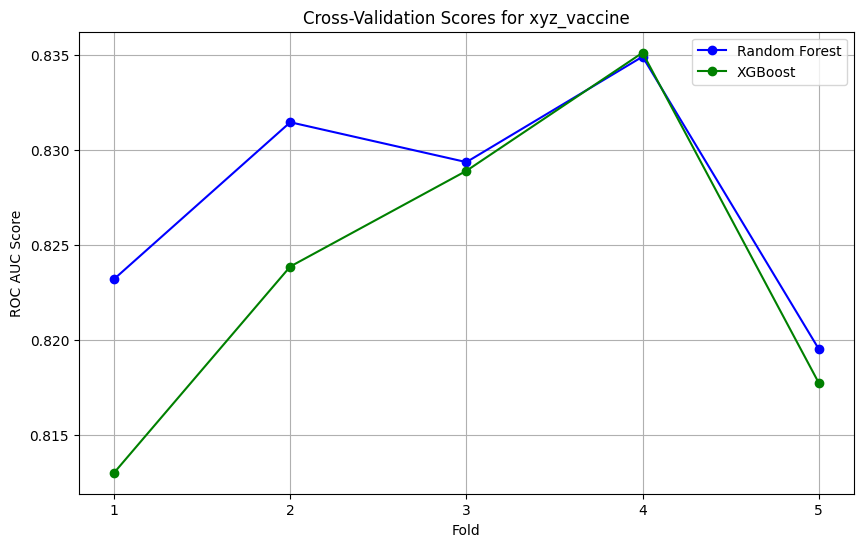

Best model for xyz_vaccine: Random Forest


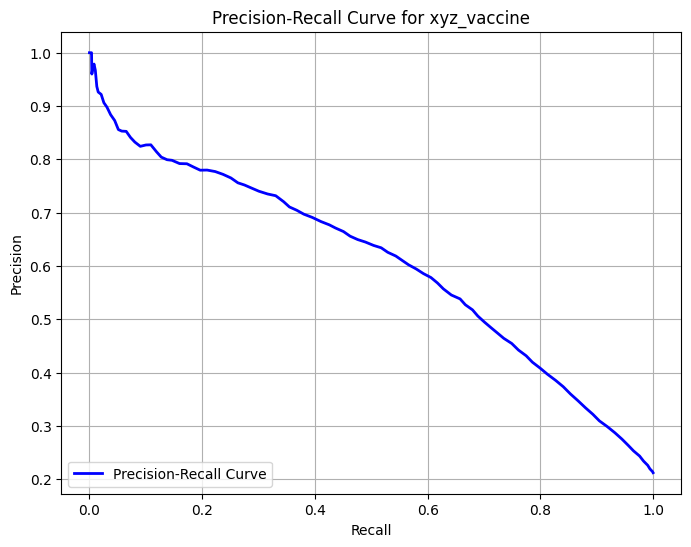

Best Threshold: 0.31


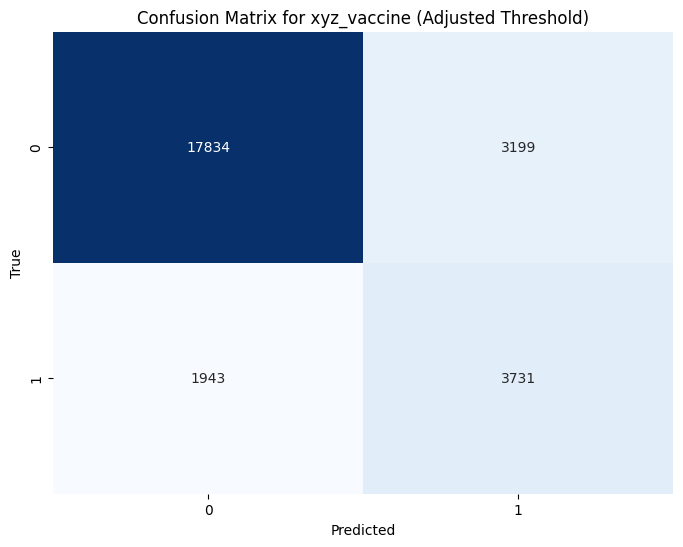

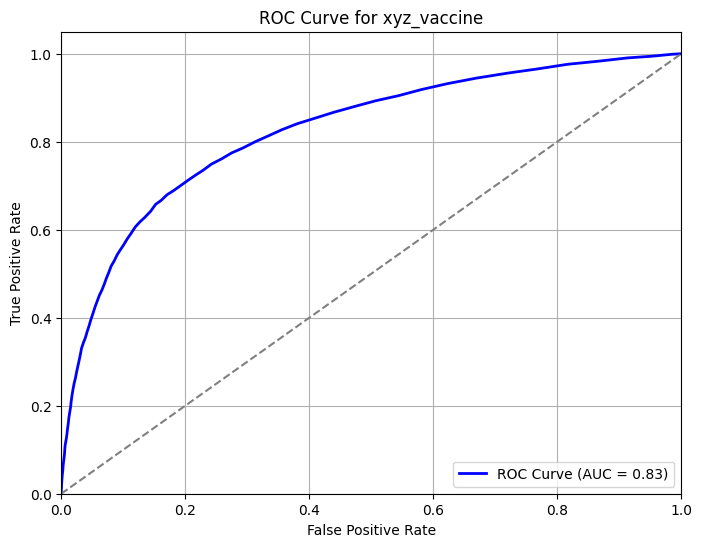

Random Forest Mean ROC AUC Score for seasonal_vaccine: 0.8510697998763581
XGBoost Mean ROC AUC Score for seasonal_vaccine: 0.8493207462349478


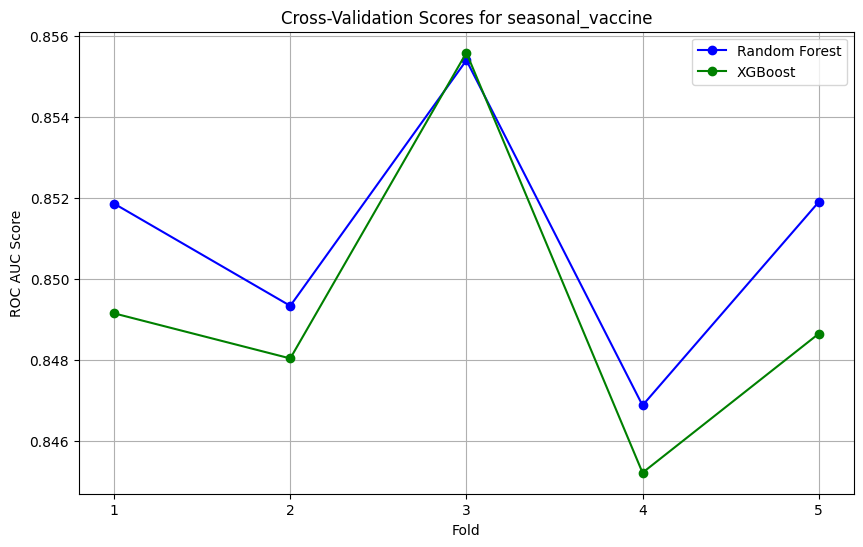

Best model for seasonal_vaccine: Random Forest


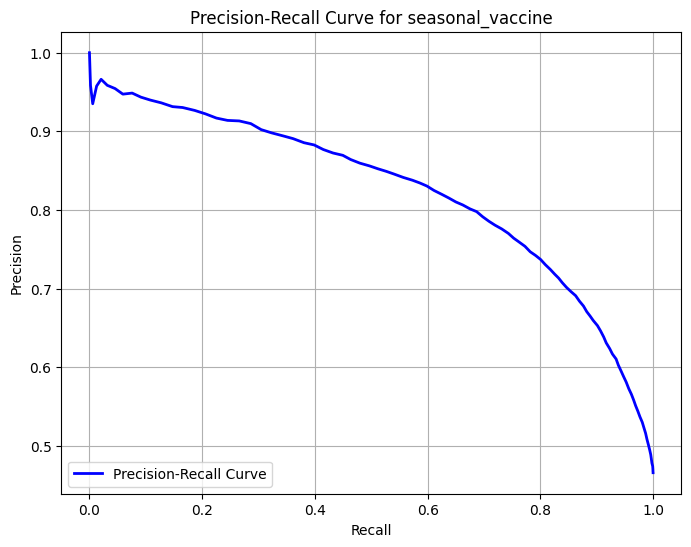

Best Threshold: 0.41


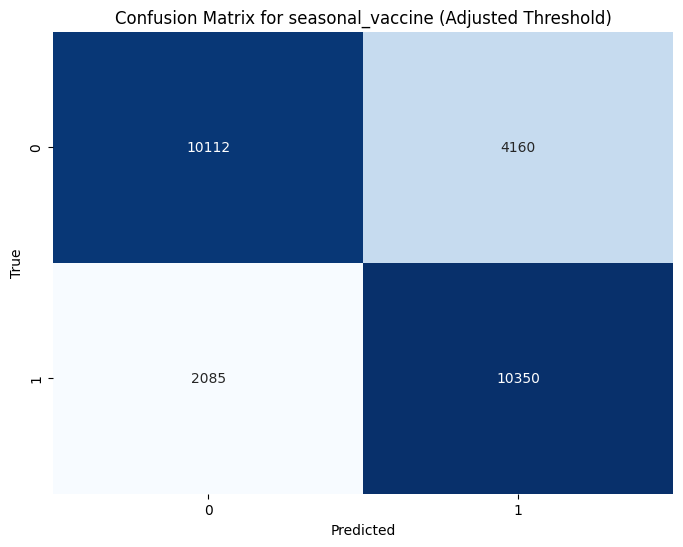

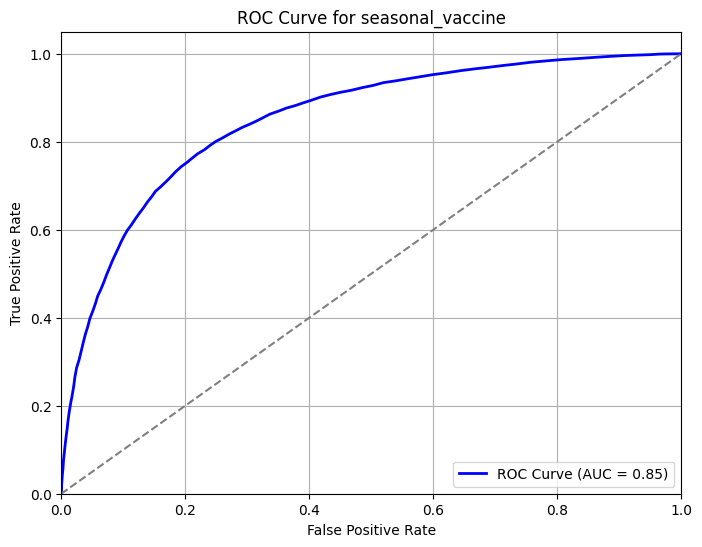

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import warnings

warnings.filterwarnings("ignore")

def custom_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred, average='macro')

def plot_roc_curve(fpr, tpr, roc_auc, target):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(precision, recall, target):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {target}')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def process_vaccine(vaccine_target):
    train_data = pd.read_csv('training_set_features.csv')
    test_data = pd.read_csv('test_set_features.csv')
    train_label = pd.read_csv('training_set_labels.csv')

    train_data = pd.merge(train_data, train_label, on='respondent_id')

    categorical_columns = [
        'age_group', 'education', 'race', 'sex', 'income_poverty',
        'marital_status', 'rent_or_own', 'employment_status', 
        'hhs_geo_region', 'census_msa', 'employment_industry', 
        'employment_occupation'
    ]

    for col in train_data.columns:
        if col in train_label.columns: 
            continue
        if train_data[col].dtype == 'object':
            train_data[col].fillna(train_data[col].mode()[0], inplace=True)
            test_data[col].fillna(test_data[col].mode()[0], inplace=True)
        else:
            train_data[col].fillna(train_data[col].median(), inplace=True)
            test_data[col].fillna(test_data[col].median(), inplace=True)

    feature_columns = [
        'xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
        'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 
        'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_xyz', 
        'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 
        'health_worker', 'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
        'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
        'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty',
        'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 
        'household_adults', 'household_children', 'employment_industry', 'employment_occupation'
    ]

    combined_data = pd.concat([train_data[categorical_columns], test_data[categorical_columns]], axis=0)

    le = LabelEncoder()
    for col in categorical_columns:
        combined_data[col] = le.fit_transform(combined_data[col].astype(str))

    train_data[categorical_columns] = combined_data[:len(train_data)][categorical_columns]
    test_data[categorical_columns] = combined_data[len(train_data):][categorical_columns]

    X_train = train_data[feature_columns]
    y_train = train_data[vaccine_target]

    rf = RandomForestClassifier()
    xgb = XGBClassifier()

    scorer = make_scorer(roc_auc_score, needs_proba=True)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    rf_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=scorer)
    xgb_scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=scorer)

    print(f"Random Forest Mean ROC AUC Score for {vaccine_target}: {rf_scores.mean()}")
    print(f"XGBoost Mean ROC AUC Score for {vaccine_target}: {xgb_scores.mean()}")

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, 6), rf_scores, marker='o', linestyle='-', color='b', label='Random Forest')
    plt.plot(np.arange(1, 6), xgb_scores, marker='o', linestyle='-', color='g', label='XGBoost')
    plt.xlabel('Fold')
    plt.ylabel('ROC AUC Score')
    plt.title(f'Cross-Validation Scores for {vaccine_target}')
    plt.xticks(np.arange(1, 6))
    plt.legend()
    plt.grid(True)
    plt.show()

    best_model = rf if rf_scores.mean() > xgb_scores.mean() else xgb
    print(f"Best model for {vaccine_target}: {'Random Forest' if best_model == rf else 'XGBoost'}")

    best_model.fit(X_train, y_train)


    y_train_pred_proba = cross_val_predict(best_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    precision, recall, thresholds_pr = precision_recall_curve(y_train, y_train_pred_proba)
    plot_precision_recall_curve(precision, recall, vaccine_target)


    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_threshold_index]
    print(f"Best Threshold: {best_threshold:.2f}")


    y_train_pred_adjusted = (y_train_pred_proba >= best_threshold).astype(int)


    conf_matrix_adjusted = confusion_matrix(y_train, y_train_pred_adjusted)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {vaccine_target} (Adjusted Threshold)')
    plt.show()

    fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred_proba)
    roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    plot_roc_curve(fpr, tpr, roc_auc, vaccine_target)

    X_test = test_data[feature_columns]
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    return y_pred_proba

y_pred_proba_xyz = process_vaccine('xyz_vaccine')
y_pred_proba_seasonal = process_vaccine('seasonal_vaccine')

submission = pd.DataFrame({
    'respondent_id': test_data['respondent_id'],
    'xyz_vaccine': y_pred_proba_xyz,
    'seasonal_vaccine': y_pred_proba_seasonal
})

submission.to_csv('submission.csv', index=False)


Range of 'xyz_vaccine' probabilities:
count    26708.000000
mean         0.219763
std          0.201466
min          0.000000
25%          0.070000
50%          0.150000
75%          0.310000
max          0.970000
Name: xyz_vaccine, dtype: float64
Range of 'seasonal_vaccine' probabilities:
count    26708.000000
mean         0.467531
std          0.279413
min          0.000000
25%          0.210000
50%          0.450000
75%          0.720000
max          1.000000
Name: seasonal_vaccine, dtype: float64
All probabilities are within the valid range [0, 1].

Sample rows from the submission file:
   respondent_id  xyz_vaccine  seasonal_vaccine
0          26707         0.14              0.28
1          26708         0.11              0.11
2          26709         0.48              0.84
3          26710         0.57              0.87
4          26711         0.18              0.51


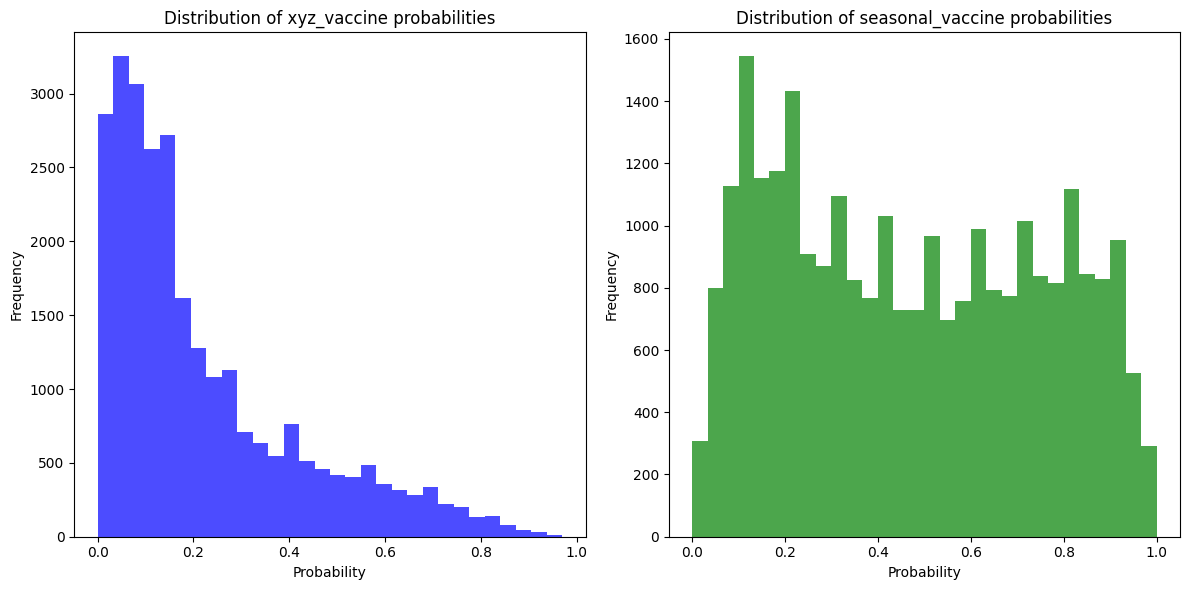

In [9]:
import pandas as pd

submission = pd.read_csv('submission.csv')

print("Range of 'xyz_vaccine' probabilities:")
print(submission['xyz_vaccine'].describe())

print("Range of 'seasonal_vaccine' probabilities:")
print(submission['seasonal_vaccine'].describe())

xyz_valid = submission['xyz_vaccine'].between(0, 1).all()
seasonal_valid = submission['seasonal_vaccine'].between(0, 1).all()

if xyz_valid and seasonal_valid:
    print("All probabilities are within the valid range [0, 1].")
else:
    print("Some probabilities are out of the valid range [0, 1].")

print("\nSample rows from the submission file:")
print(submission.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(submission['xyz_vaccine'], bins=30, alpha=0.7, color='blue')
plt.title('Distribution of xyz_vaccine probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(submission['seasonal_vaccine'], bins=30, alpha=0.7, color='green')
plt.title('Distribution of seasonal_vaccine probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()